In [1]:
import json
import numpy as np
import pandas as pd
import plotly.express as px

from itertools import product

In [2]:
def generate_parameters(initial_round, mode='random'):
    home_goals = np.array(DATA['goals_team1'][:(initial_round - 1) * 10])
    away_goals = np.array(DATA['goals_team2'][:(initial_round - 1) * 10])
    home_team = np.array(DATA['team1'][:(initial_round - 1) * 10])
    away_team = np.array(DATA['team2'][:(initial_round - 1) * 10])
    complete_home_team = np.array(DATA['team1'])
    complete_away_team = np.array(DATA['team2'])

    home_means = np.zeros(N_GAMES)
    away_means = np.zeros(N_GAMES)
    if mode == 'random' or initial_round < 5:
        home_means += np.abs(np.random.normal(size=N_GAMES))
        away_means += np.abs(np.random.normal(size=N_GAMES))
        # home_means += np.abs(np.random.normal(size=(N_SIMS, N_GAMES)))
        # away_means += np.abs(np.random.normal(size=(N_SIMS, N_GAMES)))
    elif mode == 'simple_poisson':
        lam = np.mean(np.hstack((home_goals, away_goals)))
        home_means += lam * np.ones(N_GAMES)
        away_means += lam * np.ones(N_GAMES)
    elif mode == 'club_poisson':
        for team in range(1, N_TEAMS + 1):
            goals = np.hstack((home_goals[home_team == team], away_goals[away_team == team]))
            lam = np.mean(goals)
            home_means += lam * (complete_home_team == team)
            away_means += lam * (complete_away_team == team)
    elif mode == 'club_poisson_v2':
        for team in range(1, N_TEAMS + 1):
            home_lam = np.mean(home_goals[home_team == team])
            away_lam = np.mean(away_goals[away_team == team])
            home_means += home_lam * (complete_home_team == team)
            away_means += away_lam * (complete_away_team == team)

    return home_means, away_means

In [3]:
def simulate_games(home_means, away_means, initial_round=1):
    if home_means.shape == (N_SIMS, N_GAMES):
        home_scores = np.random.poisson(home_means)
        away_scores = np.random.poisson(away_means)
    else:
        home_scores = np.random.poisson(home_means, size=(N_SIMS, home_means.shape[0]))
        away_scores = np.random.poisson(away_means, size=(N_SIMS, away_means.shape[0]))

    if initial_round > 1:
        home_goals = np.array(DATA['goals_team1'][:(initial_round - 1) * 10])
        away_goals = np.array(DATA['goals_team2'][:(initial_round - 1) * 10])
        home_scores[:, :(initial_round - 1) * 10] = home_goals
        away_scores[:, :(initial_round - 1) * 10] = away_goals

    return home_scores, away_scores

In [4]:
def calculate_standings(home_scores, away_scores, home_team, away_team):
    standings = np.zeros((N_SIMS, N_TEAMS, DIM_STATS), dtype=int)
    for i in range(N_TEAMS):
        # points
        standings[:, i, 0] += 3 * np.sum(home_scores[:, home_team == i + 1] > away_scores[:, home_team == i + 1], axis=1)
        standings[:, i, 0] += 3 * np.sum(away_scores[:, away_team == i + 1] > home_scores[:, away_team == i + 1], axis=1)
        standings[:, i, 0] += 1 * np.sum(home_scores[:, home_team == i + 1] == away_scores[:, home_team == i + 1], axis=1)
        standings[:, i, 0] += 1 * np.sum(away_scores[:, away_team == i + 1] == home_scores[:, away_team == i + 1], axis=1)

        # wins
        standings[:, i, 1] += 1 * np.sum(home_scores[:, home_team == i + 1] > away_scores[:, home_team == i + 1], axis=1)
        standings[:, i, 1] += 1 * np.sum(away_scores[:, away_team == i + 1] > home_scores[:, away_team == i + 1], axis=1)

        # goals for
        standings[:, i, 2] += np.sum(home_scores[:, home_team == i + 1], axis=1)
        standings[:, i, 2] += np.sum(away_scores[:, away_team == i + 1], axis=1)

        # goals difference
        standings[:, i, 3] += np.sum(home_scores[:, home_team == i + 1] - away_scores[:, home_team == i + 1], axis=1)
        standings[:, i, 3] += np.sum(away_scores[:, away_team == i + 1] - home_scores[:, away_team == i + 1], axis=1)

    return standings

In [5]:
def generate_final_position(array, column_indices):
    indices = np.argsort(array[..., column_indices[-1]], axis=-1)
    for col_idx in column_indices[-2::-1]:
        indices = np.take_along_axis(indices, np.argsort(np.take_along_axis(array[..., col_idx], indices, axis=-1), axis=-1), axis=-1)
    
    indices = indices[..., ::-1]
    
    return indices

In [6]:
def calculate_final_position_probabilities(final_positions):
    probabilities = np.zeros((N_TEAMS, N_TEAMS))
    for club, position in product(range(N_TEAMS), repeat=2):
        probabilities[club, position] += sum(final_positions[:, position] == club)

    return probabilities / N_SIMS

In [7]:
def simulate_championship(initial_round=1, mode='random'):
    home_team = np.array(DATA['team1'])
    away_team = np.array(DATA['team2'])

    home_means, away_means = generate_parameters(initial_round, mode=mode)
    home_scores, away_scores = simulate_games(home_means, away_means, initial_round=initial_round)
    standings = calculate_standings(home_scores, away_scores, home_team, away_team)
    standings = generate_final_position(standings, [0, 1, 2, 3])
    probabilities = calculate_final_position_probabilities(standings)

    return probabilities

In [8]:
def run_simulations(initial_rounds, mode_list, club_list):
    probs = dict()
    for initial_round, mode in product(initial_rounds, mode_list):
        print(initial_round, mode)
        if initial_round not in probs: probs[initial_round] = dict()
        if mode not in probs[initial_round]: probs[initial_round][mode] = dict()
        probabilities = simulate_championship(initial_round=initial_round, mode=mode)
        for i in range(N_TEAMS):
            team = TEAMS_NAME[i]
            if team in club_list:
                probs[initial_round][mode][team] = probabilities[i][0]
    
    return probs

In [9]:
def generate_plot(initial_rounds, mode_list, club_list, probs):
    data = []
    for initial_round in initial_rounds:
        for mode in mode_list:
            for team in club_list:
                data.append({
                    'Initial Round': initial_round,
                    'Mode': mode,
                    'Team': team,
                    'Probability': probs[initial_round][mode][team]
                })

    df = pd.DataFrame(data)

    fig = px.line(
        df,
        x='Initial Round',
        y='Probability',
        color='Team',
        line_dash='Mode' if len(mode_list) > 1 else None,
        title='Evolution of Each Team\'s Probability Over Rounds and Modes' if len(mode_list) > 1 else 'Evolution of Each Team\'s Probability Over Rounds',
        labels={
            'Initial Round': 'Initial Round',
            'Probability': 'Probability',
            'Team': 'Team',
            'Mode': 'Mode'
        }
    )

    fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(
            tickmode='array',
            tickvals=[*initial_rounds],
            showline=True,
            linewidth=2,
            linecolor='black',
            gridcolor='lightgray'
        ),
        yaxis=dict(
            showline=True,
            linewidth=2,
            linecolor='black',
            gridcolor='lightgray'
        ),
        legend_title_text='Teams and Modes' if len(mode_list) > 1 else 'Teams'
    )

    fig.show('png', width=1200)


20 club_poisson_v2
21 club_poisson_v2
22 club_poisson_v2
23 club_poisson_v2
24 club_poisson_v2
25 club_poisson_v2
26 club_poisson_v2
27 club_poisson_v2
28 club_poisson_v2
29 club_poisson_v2
30 club_poisson_v2
31 club_poisson_v2
32 club_poisson_v2
33 club_poisson_v2
34 club_poisson_v2
35 club_poisson_v2
36 club_poisson_v2
37 club_poisson_v2
38 club_poisson_v2


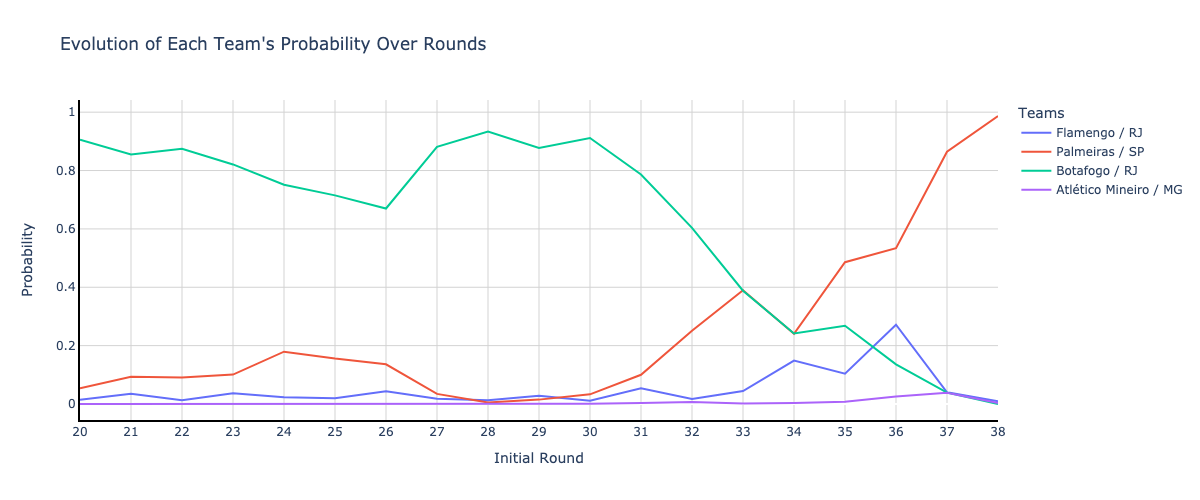

In [10]:
with open('../real_data/Poisson_model_data_2023.json', 'r') as f: DATA = json.load(f)

N_SIMS = 10_000
DIM_STATS = 4 # points, wins, goals for, goals difference
N_TEAMS = 20
N_GAMES = N_TEAMS * (N_TEAMS - 1)
TEAMS_NAME = DATA['teams']

initial_rounds = range(20, 39)
mode_list = ['club_poisson_v2']
club_list = ['Flamengo / RJ', 'Palmeiras / SP', 'Botafogo / RJ', 'Atlético Mineiro / MG']
probs = run_simulations(initial_rounds, mode_list, club_list)
generate_plot(initial_rounds, mode_list, club_list, probs)

20 club_poisson_v2
21 club_poisson_v2
22 club_poisson_v2
23 club_poisson_v2
24 club_poisson_v2
25 club_poisson_v2
26 club_poisson_v2
27 club_poisson_v2
28 club_poisson_v2
29 club_poisson_v2
30 club_poisson_v2
31 club_poisson_v2
32 club_poisson_v2
33 club_poisson_v2
34 club_poisson_v2
35 club_poisson_v2
36 club_poisson_v2
37 club_poisson_v2
38 club_poisson_v2


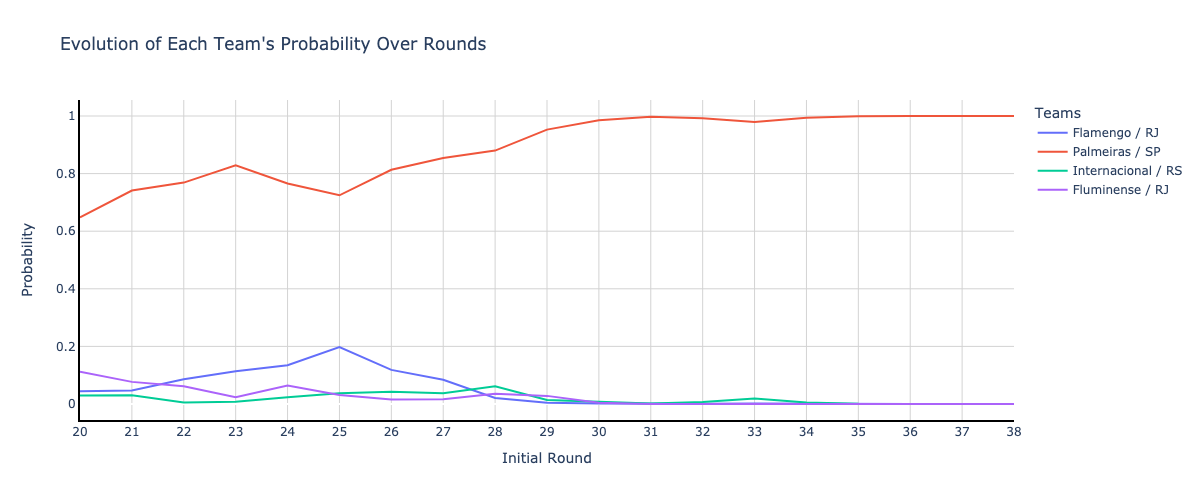

In [11]:
with open('../real_data/Poisson_model_data_2022.json', 'r') as f: DATA = json.load(f)

N_SIMS = 10_000
DIM_STATS = 4 # points, wins, goals for, goals difference
N_TEAMS = 20
N_GAMES = N_TEAMS * (N_TEAMS - 1)
TEAMS_NAME = DATA['teams']

initial_rounds = range(20, 39)
mode_list = ['club_poisson_v2']
club_list = ['Flamengo / RJ', 'Palmeiras / SP', 'Internacional / RS', 'Fluminense / RJ']
probs = run_simulations(initial_rounds, mode_list, club_list)
generate_plot(initial_rounds, mode_list, club_list, probs)

20 club_poisson_v2
21 club_poisson_v2
22 club_poisson_v2
23 club_poisson_v2
24 club_poisson_v2
25 club_poisson_v2
26 club_poisson_v2
27 club_poisson_v2
28 club_poisson_v2
29 club_poisson_v2
30 club_poisson_v2
31 club_poisson_v2
32 club_poisson_v2
33 club_poisson_v2
34 club_poisson_v2
35 club_poisson_v2
36 club_poisson_v2
37 club_poisson_v2
38 club_poisson_v2


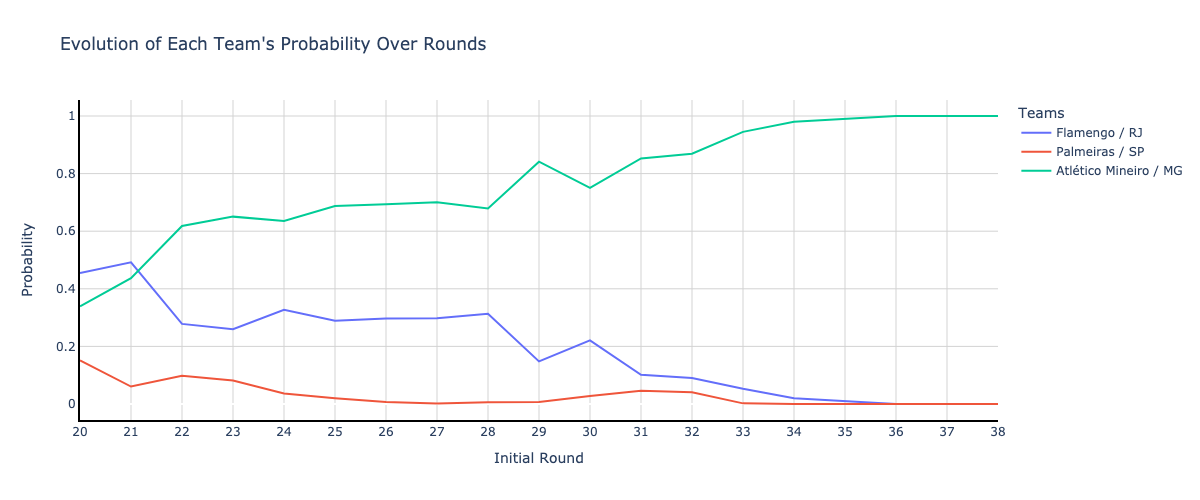

In [12]:
with open('../real_data/Poisson_model_data_2021.json', 'r') as f: DATA = json.load(f)

N_SIMS = 10_000
DIM_STATS = 4 # points, wins, goals for, goals difference
N_TEAMS = 20
N_GAMES = N_TEAMS * (N_TEAMS - 1)
TEAMS_NAME = DATA['teams']

initial_rounds = range(20, 39)
mode_list = ['club_poisson_v2']
club_list = ['Flamengo / RJ', 'Palmeiras / SP', 'Atlético Mineiro / MG']
probs = run_simulations(initial_rounds, mode_list, club_list)
generate_plot(initial_rounds, mode_list, club_list, probs)

20 club_poisson_v2
21 club_poisson_v2
22 club_poisson_v2
23 club_poisson_v2
24 club_poisson_v2
25 club_poisson_v2
26 club_poisson_v2
27 club_poisson_v2
28 club_poisson_v2
29 club_poisson_v2
30 club_poisson_v2
31 club_poisson_v2
32 club_poisson_v2
33 club_poisson_v2
34 club_poisson_v2
35 club_poisson_v2
36 club_poisson_v2
37 club_poisson_v2
38 club_poisson_v2


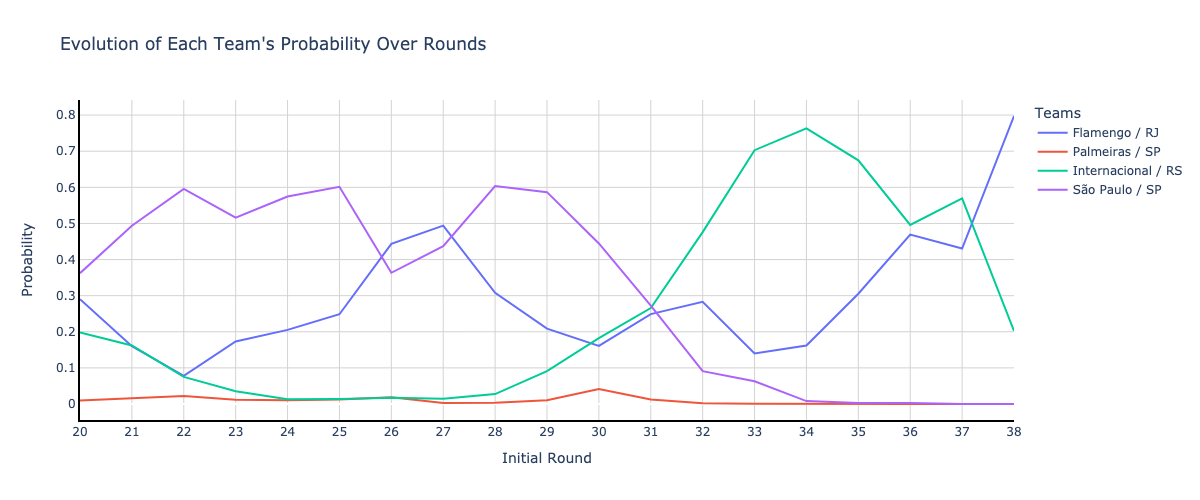

In [13]:
with open('../real_data/Poisson_model_data_2020.json', 'r') as f: DATA = json.load(f)

N_SIMS = 10_000
DIM_STATS = 4 # points, wins, goals for, goals difference
N_TEAMS = 20
N_GAMES = N_TEAMS * (N_TEAMS - 1)
TEAMS_NAME = DATA['teams']

initial_rounds = range(20, 39)
mode_list = ['club_poisson_v2']
club_list = ['Flamengo / RJ', 'Palmeiras / SP', 'Internacional / RS', 'São Paulo / SP']
probs = run_simulations(initial_rounds, mode_list, club_list)
generate_plot(initial_rounds, mode_list, club_list, probs)

20 club_poisson_v2
21 club_poisson_v2
22 club_poisson_v2
23 club_poisson_v2
24 club_poisson_v2
25 club_poisson_v2
26 club_poisson_v2
27 club_poisson_v2
28 club_poisson_v2
29 club_poisson_v2
30 club_poisson_v2
31 club_poisson_v2
32 club_poisson_v2
33 club_poisson_v2
34 club_poisson_v2
35 club_poisson_v2
36 club_poisson_v2
37 club_poisson_v2
38 club_poisson_v2


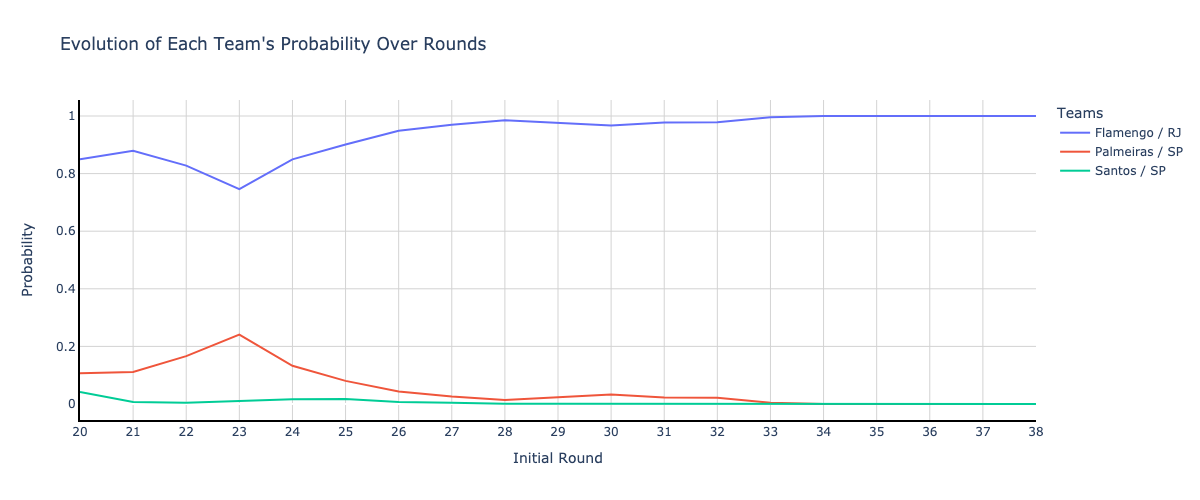

In [14]:
with open('../real_data/Poisson_model_data_2019.json', 'r') as f: DATA = json.load(f)

N_SIMS = 10_000
DIM_STATS = 4 # points, wins, goals for, goals difference
N_TEAMS = 20
N_GAMES = N_TEAMS * (N_TEAMS - 1)
TEAMS_NAME = DATA['teams']

initial_rounds = range(20, 39)
mode_list = ['club_poisson_v2']
club_list = ['Flamengo / RJ', 'Palmeiras / SP', 'Santos / SP']
probs = run_simulations(initial_rounds, mode_list, club_list)
generate_plot(initial_rounds, mode_list, club_list, probs)